In [1]:
%pylab inline
from __future__ import division
import scipy as sp
from scipy import stats
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
import operator as op
from decimal import *
import pickle
import mpld3
mpld3.enable_notebook()

Populating the interactive namespace from numpy and matplotlib


In [35]:
%run ../cow.py
%run ../optimize_pkg.py

In [18]:
protocol_target = 10**(-9)
rx_SNR_range = arange(0, 12, 0.01)
tx_SNR_range = arange(5, -10*log10(protocol_target), 0.01)
protocolbit = 4*10**4
user_range = arange(2, 36, 1)

# Walking Through Optimize 3

In [12]:
filepath_down = "../data_tables/hs_rs_downlink/n"
filepath_up = "../data_tables/hs_rs_uplink/n"
extension = ".in"
N = 30
rx_SNR_start = 3
tx_SNR_range = arange(8.5, 9.5, 0.01)

protocol = 4*10**4
downbit = upbit = xorbit = protocol/3
downTable = load_table(filepath_down+str(N)+extension)
downfunc = interp1d(downTable[0], downTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
upTable = load_table(filepath_up+str(N)+extension)
upfunc = interp1d(upTable[0], upTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

xor_table = load_table(filepath_down+str(N)+extension)
xor_func = interp1d(xor_table[0], xor_table[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

for nominal_SNR in tx_SNR_range:
    for actual_SNR in np.arange(rx_SNR_start, nominal_SNR, 0.1):
        p_add_3 = xor_func(actual_SNR)
        xor_opt = xor_analysis_opt(N, p_add_3, nominal_SNR, actual_SNR, downfunc(actual_SNR), upfunc(actual_SNR))
        if 1-xor_opt <= protocol_target:
            print (actual_SNR, nominal_SNR, downbit, upbit, xorbit)
            print 'Downlink Target', downfunc(actual_SNR)
            print 'Uplink Target', upfunc(actual_SNR)
            print 'XOR Phase Target', xor_func(actual_SNR)
            break

(3.3000000000000003, 8.7899999999999938, 13333.333333333334, 13333.333333333334, 13333.333333333334)
Downlink Target 4.14508485913e-12
Uplink Target 0.0416853564977
XOR Phase Target 4.14508485913e-12
(3.3000000000000003, 8.7999999999999936, 13333.333333333334, 13333.333333333334, 13333.333333333334)
Downlink Target 4.14508485913e-12
Uplink Target 0.0416853564977
XOR Phase Target 4.14508485913e-12
(3.3000000000000003, 8.8099999999999934, 13333.333333333334, 13333.333333333334, 13333.333333333334)
Downlink Target 4.14508485913e-12
Uplink Target 0.0416853564977
XOR Phase Target 4.14508485913e-12
(3.3000000000000003, 8.8199999999999932, 13333.333333333334, 13333.333333333334, 13333.333333333334)
Downlink Target 4.14508485913e-12
Uplink Target 0.0416853564977
XOR Phase Target 4.14508485913e-12
(3.3000000000000003, 8.829999999999993, 13333.333333333334, 13333.333333333334, 13333.333333333334)
Downlink Target 4.14508485913e-12
Uplink Target 0.0416853564977
XOR Phase Target 4.14508485913e-12
(

# Walking Through Optimize 5

In [16]:
N = 30
linktarget = downtarget = uptarget = 10**(-2)
tx_SNR_range = arange(8.5, 9.5, 0.01)

optimize_filepath_down = "../data_tables/optimize_down/n"
optimize_filepath_up = "../data_tables/optimize_up/n"

downFile = optimize_filepath_down + str(N) + '.in'
downNode = load_table(downFile)
upFile = optimize_filepath_up + str(N) + '.in'
upNode = load_table(upFile)

for nominal_SNR in tx_SNR_range:
    for actual_SNR in np.arange(max(-1, nominal_SNR-90), nominal_SNR, 0.1):
        downbit, upbit = float("inf"), float("inf")
        for bit in sorted(downNode.tables.keys()):
            bittable = downNode.tables[bit]
            downfunc = interp1d(bittable[0], bittable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
            if downfunc(actual_SNR) <= downtarget:
                downbit = bit
                break
        for bit in sorted(upNode.tables.keys()):
            bittable = upNode.tables[bit]
            upfunc = interp1d(bittable[0], bittable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
            if upfunc(actual_SNR) <= uptarget:
                upbit = bit
                break
        xorbit = protocol - downbit - upbit
        if xorbit <= 0: continue
#             xorbit = max(0, 4200 - downbit - upbit)
        # We calculate reeddrop each time because the rate changes every time (new table)
        blocklength = int(xorbit / 21)
        rate = N * 160 / xorbit * 7 / 4 if xorbit else float("inf")
        if rate > 1: continue
        k = (1-rate)*blocklength
        pbitdrop = Q(np.sqrt(2*10**(actual_SNR/10)))
        hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
        hcf = 1 - (1-hcerr)**3
        reeddrop = 1-binom.cdf(int(k/2), blocklength, hcf)
        # reeddrop = sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)])
        xor_opt = xor_analysis_opt(N, reeddrop, nominal_SNR, actual_SNR, downtarget, uptarget)
        if 1-xor_opt <= protocol_target:
            print (actual_SNR, nominal_SNR, downbit, upbit, xorbit)
            print 'Downlink Target', downfunc(actual_SNR)
            print 'Uplink Target', upfunc(actual_SNR)
            print 'XOR Phase Target', reeddrop
            break

(3.1999999999999993, 8.5099999999999998, 9200, 10992, 19808)
Downlink Target 0.00641258836825
Uplink Target 0.00768415671606
XOR Phase Target 1.11022302463e-16
(3.1999999999999993, 8.5199999999999996, 9200, 10992, 19808)
Downlink Target 0.00641258836825
Uplink Target 0.00768415671606
XOR Phase Target 1.11022302463e-16
(3.1999999999999993, 8.5299999999999994, 9200, 10992, 19808)
Downlink Target 0.00641258836825
Uplink Target 0.00768415671606
XOR Phase Target 1.11022302463e-16
(3.1999999999999993, 8.5399999999999991, 9200, 10992, 19808)
Downlink Target 0.00641258836825
Uplink Target 0.00768415671606
XOR Phase Target 1.11022302463e-16
(3.1999999999999993, 8.5499999999999989, 9200, 10992, 19808)
Downlink Target 0.00641258836825
Uplink Target 0.00768415671606
XOR Phase Target 1.11022302463e-16
(3.1999999999999993, 8.5599999999999987, 9200, 10992, 19808)
Downlink Target 0.00641258836825
Uplink Target 0.00768415671606
XOR Phase Target 1.11022302463e-16
(3.1999999999999993, 8.5699999999999985,

# Hamming + RS

In [40]:
%%time
filepath_down = "../data_tables/hs_rs_downlink/n"
filepath_up = "../data_tables/hs_rs_uplink/n"

hamming_3 = zeros((34, 5))
# rx_SNR_start = -1
d_actual_SNR = 0.1
tx_SNR_range = arange(8, 50, 0.01)
for N in user_range[::-1]:
    hamming_3[N-user_range[0]] = optimize_3(N, rx_SNR_start[N], tx_SNR_range, filepath_down, filepath_up, protocolbit, d_actual_SNR)
    print N, hamming_3[N-user_range[0]]
    
print hamming_3

35 [  7.00000000e+00   1.15800000e+01   1.46001318e-11   4.87590826e-04
   1.46001318e-11]
34 [  5.30000000e+00   1.00600000e+01   3.97588800e-12   1.83499882e-02
   3.97588800e-12]
33 [  4.50000000e+00   9.71000000e+00   3.56577027e-12   6.41360788e-02
   3.56577027e-12]
32 [  4.20000000e+00   9.79000000e+00   3.62560001e-14   9.63353840e-02
   3.62560001e-14]
31 [  4.30000000e+00   1.00000000e+01   1.44855567e-22   9.01840746e-02
   1.44855567e-22]
30 [  3.30000000e+00   8.79000000e+00   4.14508486e-12   4.16853565e-02
   4.14508486e-12]
29 [  3.20000000e+00   8.96000000e+00   2.71744444e-14   5.71596925e-02
   2.71744444e-14]
28 [  3.20000000e+00   9.20000000e+00   6.30261487e-19   6.37564306e-02
   6.30261487e-19]
27 [  2.60000000e+00   8.58000000e+00   3.58607388e-12   3.84743503e-02
   3.58607388e-12]
26 [  2.60000000e+00   8.82000000e+00   3.16265028e-15   4.46663400e-02
   3.16265028e-15]
25 [  2.70000000e+00   9.09000000e+00   2.19414274e-21   4.04603836e-02
   2.19414274e-21]

In [43]:
print hamming_3[:,0]
print hamming_3[:,1]
# print hamming_3[22,0] - (hamming_3[22,0] % 0.1)
# rx_SNR_start = {N: hamming_3[N-2, 0] - 0.1 for N in user_range}
# print rx_SNR_start

[ -3.00000000e-01  -2.00000000e-01  -1.00000000e-01  -2.22044605e-16
   2.00000000e-01   2.00000000e-01   4.00000000e-01   5.00000000e-01
   7.00000000e-01   8.00000000e-01   9.00000000e-01   9.00000000e-01
   1.00000000e+00   1.30000000e+00   1.10000000e+00   1.30000000e+00
   1.50000000e+00   1.70000000e+00   1.60000000e+00   1.90000000e+00
   1.80000000e+00   2.20000000e+00   2.10000000e+00   2.70000000e+00
   2.60000000e+00   2.60000000e+00   3.20000000e+00   3.20000000e+00
   3.30000000e+00   4.30000000e+00   4.20000000e+00   4.50000000e+00
   5.30000000e+00   7.00000000e+00]
[ 47.1   33.17  26.14  21.88  19.01  16.91  15.43  14.19  13.31  12.53
  11.92  11.3   10.82  10.62  10.04   9.84   9.65   9.59   9.14   9.19
   8.86   9.02   8.72   9.09   8.82   8.58   9.2    8.96   8.79  10.     9.79
   9.71  10.06  11.58]


In [32]:
%%time
filepath_down = "../data_tables/hs_rs_downlink/n"
filepath_up = "../data_tables/hs_rs_uplink/n"

hamming_3 = zeros((34, 5))
# rx_SNR_start = -1
tx_SNR_range = arange(8, 50, 0.01)
for N in user_range[::-1]:
    hamming_3[N-user_range[0]] = optimize_3(N, rx_SNR_start[N], tx_SNR_range, filepath_down, filepath_up, protocolbit)
    print N, hamming_3[N-user_range[0]]
    
print hamming_3

KeyboardInterrupt: 

# Shannon

In [47]:
%%time
filepath_down = "../data_tables/shannon_tables/n"
filepath_up = "../data_tables/shannon_tables/n"

shannon_3 = zeros((34, 5))
# rx_SNR_start = -17
d_actual_SNR = 0.1
tx_SNR_range = arange(1, 35, 0.01)
for N in user_range[::-1]:
    shannon_3[N-user_range[0]] = optimize_3(N, rx_SNR_start[N], tx_SNR_range, filepath_down, filepath_up, protocolbit, d_actual_SNR)
    print N, shannon_3[N-user_range[0]]
    

35 [-3.2   1.31  0.    0.    0.  ]
34 [-3.3   1.33  0.    0.    0.  ]
33 [-3.5   1.26  0.    0.    0.  ]
32 [-3.6   1.29  0.    0.    0.  ]
31 [-3.8   1.23  0.    0.    0.  ]
30 [-4.    1.17  0.    0.    0.  ]
29 [-4.1   1.23  0.    0.    0.  ]
28 [-4.3   1.19  0.    0.    0.  ]
27 [-4.5   1.16  0.    0.    0.  ]
26 [-4.7   1.14  0.    0.    0.  ]
25 [-4.9   1.14  0.    0.    0.  ]
24 [-5.1   1.14  0.    0.    0.  ]
23 [-5.3   1.17  0.    0.    0.  ]
22 [-5.5  1.2  0.   0.   0. ]
21 [-5.8   1.16  0.    0.    0.  ]
20 [-6.    1.24  0.    0.    0.  ]
19 [-6.2   1.34  0.    0.    0.  ]
18 [-6.5   1.37  0.    0.    0.  ]
17 [-6.8   1.44  0.    0.    0.  ]
16 [-7.1   1.54  0.    0.    0.  ]
15 [-7.4   1.69  0.    0.    0.  ]
14 [-7.7   1.89  0.    0.    0.  ]
13 [-8.    2.17  0.    0.    0.  ]
12 [-8.4   2.42  0.    0.    0.  ]
11 [-8.8   2.78  0.    0.    0.  ]
10 [ -9.30000000e+00   3.27000000e+00   1.67510450e-10   1.67510450e-10
   1.67510450e-10]
9 [-9.7   3.86  0.    0.    0.  ]
8 [-1

In [46]:
print shannon_3[:,0]
rx_SNR_start = {N: shannon_3[N-2, 0] - 1 for N in user_range}
print rx_SNR_start

[-16. -14. -13. -12. -11. -10. -10.  -9.  -9.  -8.  -8.  -8.  -7.  -7.  -7.
  -6.  -6.  -6.  -6.  -5.  -5.  -5.  -5.  -4.  -4.  -4.  -4.  -4.  -4.  -3.
  -3.  -3.  -3.  -3.]
{2: -17.0, 3: -15.0, 4: -14.0, 5: -13.0, 6: -12.0, 7: -11.0, 8: -11.0, 9: -10.0, 10: -10.0, 11: -9.0, 12: -9.0, 13: -9.0, 14: -8.0, 15: -8.0, 16: -8.0, 17: -7.0, 18: -7.0, 19: -7.0, 20: -7.0, 21: -6.0, 22: -6.0, 23: -6.0, 24: -6.0, 25: -5.0, 26: -5.0, 27: -5.0, 28: -5.0, 29: -5.0, 30: -5.0, 31: -4.0, 32: -4.0, 33: -4.0, 34: -4.0, 35: -4.0}


# Hard Shannon

In [52]:
%%time
filepath_down = "../data_tables/hard_shannon_tables/n"
filepath_up = "../data_tables/hard_shannon_tables/n"

hardshannon_3 = zeros((34, 5))
# rx_SNR_start = -17
d_actual_SNR = 0.1
tx_SNR_range = arange(1, 35, 0.01)
for N in user_range[::-1]:
    hardshannon_3[N-user_range[0]] = optimize_3(N, rx_SNR_start[N], tx_SNR_range, filepath_down, filepath_up, protocolbit, d_actual_SNR)
    print N, hardshannon_3[N-user_range[0]]
    

35 [-0.4   4.11  0.    0.    0.  ]
34 [-0.6   4.03  0.    0.    0.  ]
33 [-0.8   3.96  0.    0.    0.  ]
32 [-1.    3.89  0.    0.    0.  ]
31 [-1.2   3.83  0.    0.    0.  ]
30 [-1.4   3.77  0.    0.    0.  ]
29 [-1.6   3.73  0.    0.    0.  ]
28 [-1.8   3.69  0.    0.    0.  ]
27 [-2.1   3.56  0.    0.    0.  ]
26 [-2.3   3.54  0.    0.    0.  ]
25 [-2.5   3.54  0.    0.    0.  ]
24 [-2.7   3.54  0.    0.    0.  ]
23 [-3.    3.47  0.    0.    0.  ]
22 [-3.2  3.5  0.   0.   0. ]
21 [-3.5   3.46  0.    0.    0.  ]
20 [-3.7   3.54  0.    0.    0.  ]
19 [-4.    3.54  0.    0.    0.  ]
18 [-4.3   3.57  0.    0.    0.  ]
17 [-4.6   3.64  0.    0.    0.  ]
16 [-4.9   3.74  0.    0.    0.  ]
15 [-5.2   3.89  0.    0.    0.  ]
14 [-5.5   4.09  0.    0.    0.  ]
13 [-5.9   4.27  0.    0.    0.  ]
12 [-6.3   4.52  0.    0.    0.  ]
11 [-6.7   4.88  0.    0.    0.  ]
10 [-7.2   5.28  0.    0.    0.  ]
9 [-7.7   5.86  0.    0.    0.  ]
8 [-8.2   6.68  0.    0.    0.  ]
7 [-8.8   7.75  0.    0.   

In [51]:
print hardshannon_3[:,0]
rx_SNR_start = {N: hardshannon_3[N-2, 0] - 1 for N in user_range}
print rx_SNR_start

[-14. -12. -11. -10.  -9.  -8.  -8.  -7.  -7.  -6.  -6.  -5.  -5.  -5.  -4.
  -4.  -4.  -4.  -3.  -3.  -3.  -3.  -2.  -2.  -2.  -2.  -1.  -1.  -1.  -1.
  -1.   0.   0.   0.]
{2: -15.0, 3: -13.0, 4: -12.0, 5: -11.0, 6: -10.0, 7: -9.0, 8: -9.0, 9: -8.0, 10: -8.0, 11: -7.0, 12: -7.0, 13: -6.0, 14: -6.0, 15: -6.0, 16: -5.0, 17: -5.0, 18: -5.0, 19: -5.0, 20: -4.0, 21: -4.0, 22: -4.0, 23: -4.0, 24: -3.0, 25: -3.0, 26: -3.0, 27: -3.0, 28: -2.0, 29: -2.0, 30: -2.0, 31: -2.0, 32: -2.0, 33: -1.0, 34: -1.0, 35: -1.0}


# Polyanskiy

In [57]:
%%time
filepath_down = "../data_tables/polyanskiy_down/n"
filepath_up = "../data_tables/polyanskiy_up/n"

poly_3 = zeros((34, 5))
# rx_SNR_start = -17
d_actual_SNR = 0.1
tx_SNR_range = arange(2, 35, 0.01)
for N in user_range[::-1]:
    poly_3[N-user_range[0]] = optimize_3(N, rx_SNR_start[N], tx_SNR_range, filepath_down, filepath_up, protocolbit, d_actual_SNR)
    print N, poly_3[N-user_range[0]]
    

35 [ -2.20000000e+00   2.53000000e+00   6.45702577e-27   3.55454057e-02
   6.45702577e-27]
34 [ -2.40000000e+00   2.51000000e+00   5.94122557e-24   4.27883525e-02
   5.94122557e-24]
33 [ -2.50000000e+00   2.48000000e+00   8.23994691e-26   3.45955331e-02
   8.23994691e-26]
32 [ -2.70000000e+00   2.46000000e+00   2.78117659e-23   4.04961223e-02
   2.78117659e-23]
31 [ -2.80000000e+00   2.45000000e+00   2.29478898e-25   3.16323368e-02
   2.29478898e-25]
30 [ -3.00000000e+00   2.43000000e+00   3.07330788e-23   3.59023332e-02
   3.07330788e-23]
29 [ -3.20000000e+00   2.42000000e+00   1.96714223e-21   3.98942392e-02
   1.96714223e-21]
28 [ -3.30000000e+00   2.41000000e+00   7.70274302e-24   2.94044087e-02
   7.70274302e-24]
27 [ -3.50000000e+00   2.41000000e+00   2.14591631e-22   3.14555363e-02
   2.14591631e-22]
26 [ -3.70000000e+00   2.42000000e+00   3.15363077e-21   3.28475282e-02
   3.15363077e-21]
25 [ -3.90000000e+00   2.43000000e+00   2.54014523e-20   3.34414620e-02
   2.54014523e-20]

In [58]:
print poly_3[:,0]
# rx_SNR_start = {N: poly_3[N-2, 0] - 1 for N in user_range}
# print rx_SNR_start

[-13.7 -12.4 -11.4 -10.6  -9.9  -9.3  -8.8  -8.3  -7.8  -7.5  -7.1  -6.8
  -6.4  -6.1  -5.9  -5.6  -5.4  -5.1  -4.9  -4.7  -4.5  -4.2  -4.   -3.9
  -3.7  -3.5  -3.3  -3.2  -3.   -2.8  -2.7  -2.5  -2.4  -2.2]


# Polyanskiy BSC

In [59]:
%%time
filepath_down = "../data_tables/poly_bsc_converse/down/n"
filepath_up = "../data_tables/poly_bsc_converse/up/n"

bsc_3 = zeros((34, 5))
rx_SNR_start = -14
d_actual_SNR = 1
tx_SNR_range = arange(2, 35, 0.01)
for N in user_range[::-1]:
    bsc_3[N-user_range[0]] = optimize_3(N, rx_SNR_start, tx_SNR_range, filepath_down, filepath_up, protocolbit, d_actual_SNR)
    print N, bsc_3[N-user_range[0]]
    

35 [  1.00000000e+00   5.55000000e+00   1.11022302e-16   6.12422153e-03
   1.11022302e-16]
34 [  1.00000000e+00   5.65000000e+00   1.11022302e-16   2.46444063e-03
   1.11022302e-16]
33 [  0.00000000e+00   5.22000000e+00   5.55111513e-16   6.82214493e-02
   5.55111513e-16]
32 [  0.00000000e+00   5.11000000e+00   2.22044605e-16   3.28846081e-02
   2.22044605e-16]
31 [  0.00000000e+00   5.12000000e+00   2.22044605e-16   1.34500637e-02
   2.22044605e-16]
30 [  0.00000000e+00   5.21000000e+00   2.22044605e-16   5.07933397e-03
   2.22044605e-16]
29 [  0.00000000e+00   5.34000000e+00   1.11022302e-16   1.70255037e-03
   1.11022302e-16]
28 [ -1.00000000e+00   4.91000000e+00   4.21884749e-15   5.35067140e-02
   4.21884749e-15]
27 [ -1.00000000e+00   4.85000000e+00   1.11022302e-16   2.34554495e-02
   1.11022302e-16]
26 [ -1.00000000e+00   4.91000000e+00   1.11022302e-16   8.89976632e-03
   1.11022302e-16]
25 [ -1.00000000e+00   5.06000000e+00   2.22044605e-16   2.52773510e-03
   2.22044605e-16]

In [64]:
print bsc_3[:, 0]
rx_SNR_start = {N: bsc_3[N-2, 0] - 1 for N in user_range}
rx_SNR_start[2] = -17
print rx_SNR_start

[ inf -10.  -9.  -9.  -8.  -7.  -7.  -6.  -6.  -5.  -5.  -4.  -4.  -4.  -4.
  -3.  -3.  -3.  -2.  -2.  -2.  -2.  -1.  -1.  -1.  -1.  -1.   0.   0.   0.
   0.   0.   1.   1.]
{2: -17, 3: -11.0, 4: -10.0, 5: -10.0, 6: -9.0, 7: -8.0, 8: -8.0, 9: -7.0, 10: -7.0, 11: -6.0, 12: -6.0, 13: -5.0, 14: -5.0, 15: -5.0, 16: -5.0, 17: -4.0, 18: -4.0, 19: -4.0, 20: -3.0, 21: -3.0, 22: -3.0, 23: -3.0, 24: -2.0, 25: -2.0, 26: -2.0, 27: -2.0, 28: -2.0, 29: -1.0, 30: -1.0, 31: -1.0, 32: -1.0, 33: -1.0, 34: 0.0, 35: 0.0}


In [65]:
%%time
filepath_down = "../data_tables/poly_bsc_converse/down/n"
filepath_up = "../data_tables/poly_bsc_converse/up/n"

bsc_3 = zeros((34, 5))
# rx_SNR_start = -14
d_actual_SNR = 0.1
tx_SNR_range = arange(2, 35, 0.01)
for N in user_range[::-1]:
    bsc_3[N-user_range[0]] = optimize_3(N, rx_SNR_start[N], tx_SNR_range, filepath_down, filepath_up, protocolbit, d_actual_SNR)
    print N, bsc_3[N-user_range[0]]
    

35 [  5.00000000e-01   5.30000000e+00   1.11022302e-16   4.53739085e-02
   1.11022302e-16]
34 [  3.00000000e-01   5.25000000e+00   1.11022302e-16   4.88316660e-02
   1.11022302e-16]
33 [  1.00000000e-01   5.19000000e+00   1.11022302e-16   4.94306475e-02
   1.11022302e-16]
32 [ -1.00000000e-01   5.11000000e+00   2.22044605e-16   4.69014055e-02
   2.22044605e-16]
31 [ -3.00000000e-01   5.03000000e+00   2.22044605e-16   4.35246710e-02
   2.22044605e-16]
30 [ -5.00000000e-01   4.98000000e+00   2.22044605e-16   4.26718878e-02
   2.22044605e-16]
29 [ -6.00000000e-01   4.94000000e+00   1.11022302e-16   2.93685674e-02
   1.11022302e-16]
28 [ -9.00000000e-01   4.88000000e+00   2.22044605e-16   3.74979876e-02
   2.22044605e-16]
27 [ -1.10000000e+00   4.84000000e+00   1.11022302e-16   3.47057664e-02
   1.11022302e-16]
26 [ -1.30000000e+00   4.81000000e+00   1.11022302e-16   3.23768835e-02
   1.11022302e-16]
25 [ -1.50000000e+00   4.78000000e+00   2.22044605e-16   2.77160214e-02
   2.22044605e-16]

# Error Exponent

In [68]:
%%time
filepath_down = "../data_tables/error_exp/down/n"
filepath_up = "../data_tables/error_exp/up/n"

exp_3 = zeros((34, 5))
rx_SNR_start = -14
d_actual_SNR = 1
tx_SNR_range = arange(2, 35, 0.01)
for N in user_range[::-1]:
    exp_3[N-user_range[0]] = optimize_3(N, rx_SNR_start, tx_SNR_range, filepath_down, filepath_up, protocolbit, d_actual_SNR)
    print N, exp_3[N-user_range[0]]
    

35 [  1.00000000e+00   5.92000000e+00   8.75701739e-43   6.28569110e-02
   8.75701739e-43]
34 [  1.00000000e+00   5.80000000e+00   2.13532648e-54   2.63909383e-02
   2.13532648e-54]
33 [  1.00000000e+00   5.82000000e+00   1.50605888e-67   9.44248100e-03
   1.50605888e-67]
32 [  1.00000000e+00   5.91000000e+00   2.74687361e-82   2.82627039e-03
   2.74687361e-82]
31 [  0.00000000e+00   5.96000000e+00   2.08858374e-29   1.18804785e-01
   2.08858374e-29]
30 [  0.00000000e+00   5.56000000e+00   4.64208006e-39   5.27501567e-02
   4.64208006e-39]
29 [  0.00000000e+00   5.47000000e+00   2.98229648e-50   1.95986380e-02
   2.98229648e-50]
28 [  0.00000000e+00   5.53000000e+00   4.80751677e-63   5.94777203e-03
   4.80751677e-63]
27 [  0.00000000e+00   5.67000000e+00   1.66443732e-77   1.43332026e-03
   1.66443732e-77]
26 [ -1.00000000e+00   5.61000000e+00   1.44035669e-28   8.49516709e-02
   1.44035669e-28]
25 [ -1.00000000e+00   5.31000000e+00   2.12202591e-38   3.11221812e-02
   2.12202591e-38]

In [69]:
print exp_3[:, 0]
rx_SNR_start = {N: exp_3[N-2, 0] - 1 for N in user_range}
rx_SNR_start[2] = -14
print rx_SNR_start

[ inf -10.  -9.  -8.  -7.  -7.  -6.  -6.  -5.  -5.  -4.  -4.  -4.  -3.  -3.
  -3.  -2.  -2.  -2.  -2.  -1.  -1.  -1.  -1.  -1.   0.   0.   0.   0.   0.
   1.   1.   1.   1.]
{2: -14, 3: -11.0, 4: -10.0, 5: -9.0, 6: -8.0, 7: -8.0, 8: -7.0, 9: -7.0, 10: -6.0, 11: -6.0, 12: -5.0, 13: -5.0, 14: -5.0, 15: -4.0, 16: -4.0, 17: -4.0, 18: -3.0, 19: -3.0, 20: -3.0, 21: -3.0, 22: -2.0, 23: -2.0, 24: -2.0, 25: -2.0, 26: -2.0, 27: -1.0, 28: -1.0, 29: -1.0, 30: -1.0, 31: -1.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0}


In [70]:
%%time
filepath_down = "../data_tables/error_exp/down/n"
filepath_up = "../data_tables/error_exp/up/n"

exp_3 = zeros((34, 5))
# rx_SNR_start = -14
d_actual_SNR = 0.1
tx_SNR_range = arange(2, 35, 0.01)
for N in user_range:
    exp_3[N-user_range[0]] = optimize_3(N, rx_SNR_start[N], tx_SNR_range, filepath_down, filepath_up, protocolbit, d_actual_SNR)
    print N, exp_3[N-user_range[0]]
    

2 [            inf             inf  13333.33333333  13333.33333333
  13333.33333333]
3 [ -1.03000000e+01   2.31000000e+01   3.02706945e-15   1.44657447e-05
   3.02706945e-15]
4 [ -9.20000000e+00   1.70300000e+01   9.34119183e-17   9.83106512e-05
   9.34119183e-17]
5 [ -8.30000000e+00   1.35100000e+01   1.47030406e-18   2.71319764e-04
   1.47030406e-18]
6 [ -7.60000000e+00   1.12500000e+01   3.40947535e-19   8.35823529e-04
   3.40947535e-19]
7 [ -7.00000000e+00   9.72000000e+00   1.20288265e-19   1.98232451e-03
   1.20288265e-19]
8 [ -6.40000000e+00   8.62000000e+00   9.78868564e-22   2.36505120e-03
   9.78868564e-22]
9 [ -5.90000000e+00   7.81000000e+00   8.21675173e-23   3.51623422e-03
   8.21675173e-23]
10 [ -5.40000000e+00   7.21000000e+00   3.64477419e-25   3.59887749e-03
   3.64477419e-25]
11 [ -5.00000000e+00   6.74000000e+00   1.08910401e-25   5.37827084e-03
   1.08910401e-25]
12 [ -4.60000000e+00   6.38000000e+00   4.04917702e-27   6.31849865e-03
   4.04917702e-27]
13 [ -4.2000

# Plots

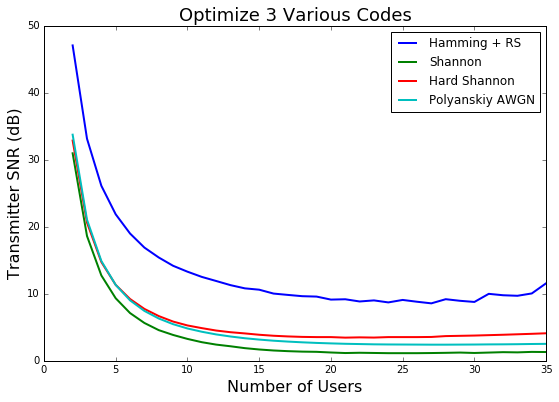

In [62]:
figure(figsize=(9, 6))
plot(user_range, hamming_3[:,1], lw=2.0, label='Hamming + RS')
plot(user_range, shannon_3[:,1], lw=2.0, label='Shannon')
plot(user_range, hardshannon_3[:,1], lw=2.0, label='Hard Shannon')
plot(user_range, poly_3[:,1], lw=2.0, label='Polyanskiy AWGN')
legend(loc=0)
title('Optimize 3 Various Codes', fontsize=18)
xlabel('Number of Users', fontsize=16)
ylabel('Transmitter SNR (dB)', fontsize=16)
savefig('optimize_3_codes.pdf', bbox='tight')

In [71]:
optimize_3_codes = {
    'hamming' : hamming_3[:,1],
    'shannon' : shannon_3[:,1],
    'hardshannon' : hardshannon_3[:,1],
    'polyanskiy' : poly_3[:,1],
    'bsc' : bsc_3[:,1],
    'error_exp' : exp_3[:,1]
}

In [72]:
print optimize_3_codes

{'hardshannon': array([ 32.89,  20.64,  14.75,  11.34,   9.23,   7.75,   6.68,   5.86,
         5.28,   4.88,   4.52,   4.27,   4.09,   3.89,   3.74,   3.64,
         3.57,   3.54,   3.54,   3.46,   3.5 ,   3.47,   3.54,   3.54,
         3.54,   3.56,   3.69,   3.73,   3.77,   3.83,   3.89,   3.96,
         4.03,   4.11]), 'polyanskiy': array([ 33.77,  21.07,  14.91,  11.33,   9.03,   7.45,   6.32,   5.47,
         4.83,   4.34,   3.94,   3.63,   3.37,   3.17,   3.  ,   2.87,
         2.76,   2.67,   2.6 ,   2.54,   2.5 ,   2.46,   2.44,   2.43,
         2.42,   2.41,   2.41,   2.42,   2.43,   2.45,   2.46,   2.48,
         2.51,   2.53]), 'hamming': array([ 47.1 ,  33.17,  26.14,  21.88,  19.01,  16.91,  15.43,  14.19,
        13.31,  12.53,  11.92,  11.3 ,  10.82,  10.62,  10.04,   9.84,
         9.65,   9.59,   9.14,   9.19,   8.86,   9.02,   8.72,   9.09,
         8.82,   8.58,   9.2 ,   8.96,   8.79,  10.  ,   9.79,   9.71,
        10.06,  11.58]), 'bsc': array([   inf,  22.75,  1

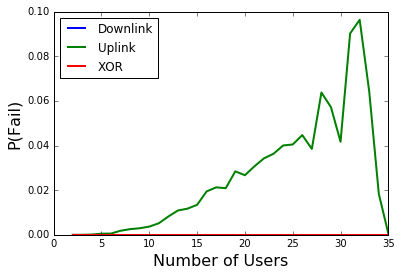

In [74]:
plot(user_range, hamming_3[:,2], lw=2.0, label='Downlink')
plot(user_range, hamming_3[:,3], lw=2.0, label='Uplink')
plot(user_range, hamming_3[:,4], lw=2.0, label='XOR')
legend(loc=0)
xlabel('Number of Users', fontsize=16)
ylabel('P(Fail)', fontsize=16)
savefig('optimize_5_target_phases.pdf', bbox='tight')